In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [ ]:
num_pts = 10
v = 10/6
dt = 0.1
num_st_pts = int(v/dt)

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    theta = (-2*x**3 + 3*x**2)*(theta_f - theta_i) + theta_i
    return theta 

def straight(dist, curr_pose = (0,0,np.pi/2), n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x,y,theta = curr_pose
    xf = x + dist*np.cos(theta)
    yf = y + dist*np.sin(theta)
    x_traj = np.linspace(0,1,n)*(xf - x) + x
    y_traj = np.linspace(0,1,n)*(yf-y) + y  
    return (x_traj, y_traj, theta*np.ones_like(x_traj))

def turn(change, curr_pose = (0,0,np.pi/2), n = num_pts):
    #adjust scaling constant for desired turn radius
    x0,y0,curr_theta = curr_pose
    theta = cubic_spiral(curr_theta, curr_theta + np.deg2rad(change), n)
    x = x0 + np.cumsum(v*np.cos(theta)*dt)
    y = y0 + np.cumsum(v*np.sin(theta)*dt)
    return x, y, theta 

def generate_trajectory(route, init_pose = (0,0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command,curr_pose)
        curr_pose = px[-1],py[-1], pt[-1]
        # update x, y, t using np.concatenate and px,py,pt
        x = np.concatenate([x,px])
        y = np.concatenate([y,py])
        t = np.concatenate([t,pt])
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

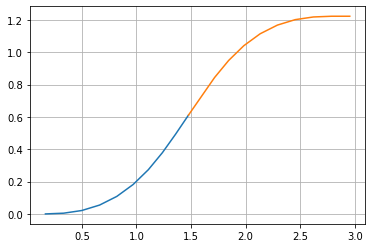

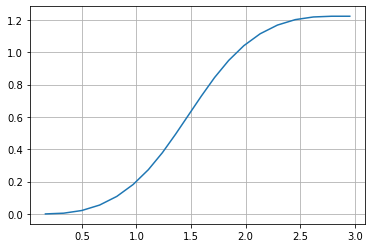

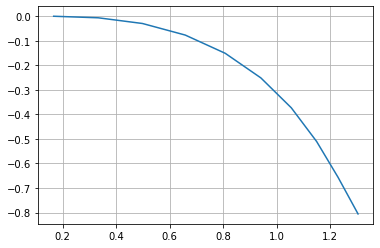

In [49]:
theta = cubic_spiral(0,np.pi/4)
x = np.cumsum(v*np.cos(theta)*dt)
y = np.cumsum(v*np.sin(theta)*dt)
plt.figure()
plt.plot(x,y)
theta = cubic_spiral(np.pi/4,0)
x1 = x[-1] + np.cumsum(v*np.cos(theta)*dt)
y1 = y[-1] + np.cumsum(v*np.sin(theta)*dt)
x1[0] -= v*np.cos(theta[0])*dt
y1[0] -= v*np.sin(theta[0])*dt
plt.plot(x1,y1)
plt.grid()
plt.figure()
num_pts = 5
x,y,theta = generate_trajectory([("turn", 45),("turn",-45)],(0,0,0))
num_pts = 10
plt.plot(x,y)
plt.grid()
plt.figure()
plt.grid()
alpha = np.rad2deg(np.arctan(-2))
x,y,_ = generate_trajectory([("turn",alpha)],(0,0,0))
plt.plot(x,y)

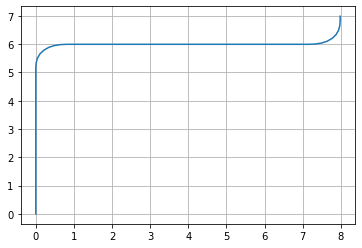

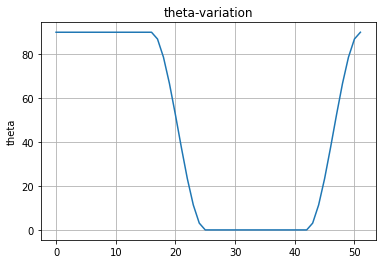

In [ ]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x,y,theta = generate_trajectory(route)
plt.figure()
plt.plot(x,y)
plt.grid()
plt.figure()
plt.plot(np.rad2deg(theta))
plt.title("theta-variation")
plt.ylabel("theta")
plt.grid()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

corner [[0 6]]
Route:[('straight', 5), ('turn', -90.0), ('straight', 5)]


Text(0.5, 1.0, 'smooth path')

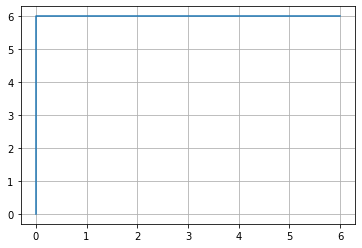

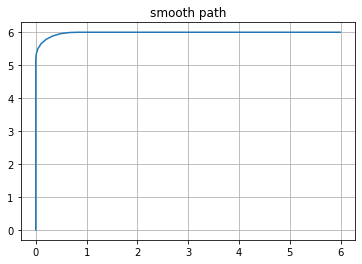

In [ ]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1+1)) # 1 is added to make the line segments consistenet with its length = 6
x1 = [0]*s1

x2 = list(range(s2+1))
y2 = [y1[-1]]*s2

x, y = x1+x2, y1+y2
plt.figure()
plt.plot(x, y)
plt.grid()
corners = []
#find the corner point and plot it
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3 - x2)*(y2-y1)
  if slope !=0:
    corners.append([x2,y2])
corners = np.array(corners)
print('corner', corners)
# Fix a turn radius r
r = 1
# Shorten the straight segments by r
for i,j in zip(x,y):
  if (i== corners[0,0]) and (j == corners[0,1]):
    x.remove(i)
    y.remove(j)
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}  
x0,y0 = x[0],y[0]
m_old = None
route = []
theta_turn = 0
for i,j in zip(x[1:],y[1:]):
  try:
    m = (j-y0)/(i-x0)
  except ZeroDivisionError:
    m = np.inf
  if m_old is None: 
    x0,y0 = i,j
    m_old = m
    continue
  theta_turn += np.rad2deg(np.arctan(m) - np.arctan(m_old))
  #print(f"m_old:{m_old} m:{m}  theta:{theta_turn}")
  if (m_old != m) and (abs(theta_turn) != 90):
    length_s = s1-r
    route.append(("straight",length_s))
  elif (m_old != m) and (abs(theta_turn) == 90):
    route.append(("turn",theta_turn))
  elif (i == x[-1]) and (j == y[-1]):
    length_s = s2-r
    route.append(("straight",length_s))
  x0,y0 = i,j
  m_old = m
print(f"Route:{route}")
# use generate_trajectory() and plot the smooth path
x_traj, y_traj,_ = generate_trajectory(route)
plt.figure()
plt.plot(x_traj,y_traj)
plt.grid()
plt.title("smooth path")

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
#link = 'https://drive.google.com/file/d/1QUVPOnC-nL6ClG9dNbkPF8KpviloMRH-/view?usp=sharing'
downloaded = drive.CreateFile({'id':"1QUVPOnC-nL6ClG9dNbkPF8KpviloMRH-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('astar_grid.npy') 

In [ ]:
import networkx as nx
def euclidean(node1, node2):
  x1, y1 = node1
  x2, y2 = node2
  return np.sqrt((x1-x2)**2 + (y1-y2)**2)

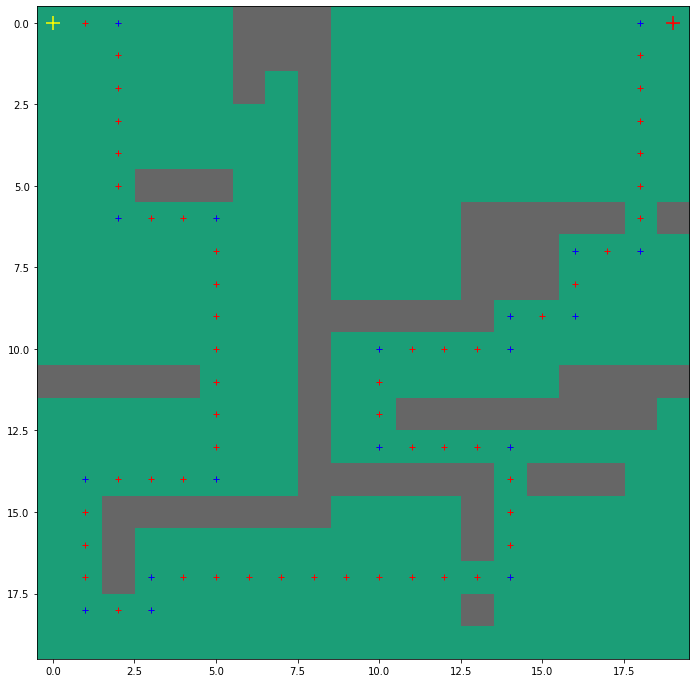

In [ ]:
grid = np.load("astar_grid.npy")
start = (0, 0)
goal = (0, 19)
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)
num_nodes = 0
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i, j] == 1: 
      G.remove_node((i, j))
      num_nodes += 1
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, "cost")
astar_path = nx.astar_path(G, start, goal, heuristic=euclidean, weight="cost")
astar_path = np.array(astar_path)
corners = []
x,y = astar_path[:,0], astar_path[:,1]
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3 - x2)*(y2-y1)
  if slope !=0:
    corners.append([x2,y2])
corners = np.array(corners)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')
for s in corners:
  ax.plot(s[1],s[0],'b+')

In [ ]:
for i, j in corners:
  idx = np.sum([i,j] == astar_path,axis=1)
  idx = np.argmax(idx)
  #idx = np.unravel_index(idx,astar_path.shape)
  astar_path = np.delete(astar_path,idx,0)
print(x.shape, astar_path.shape, corners.shape)


(72,) (54, 2) (18, 2)


In [ ]:
x,y = astar_path[:,0], astar_path[:,1]
x0,y0 = x[0],y[0]
x_seg,y_seg = x0,y0
m_old = None
route_astar = []
sgm = lambda x: abs(x)/x 
for i, j in zip(x[1:],y[1:]):
  try: 
    m = (j-y0)/(i-x0)
  except ZeroDivisionError:
    m = np.inf
  if m_old is None:
    m_old = m
    x0,y0 = i,j
    continue
  if  (abs(m) != np.inf) and (m != 0) :
    dist = np.sqrt((x0-x_seg)**2 + (y0-y_seg)**2)
    theta_slope = np.rad2deg(np.arctan(m) - np.arctan(m_old))
    sign = sgm(theta_slope)
    route_astar.append(("straight",dist))
    route_astar.append(("turn", sign*90))
    if abs(m) !=1:
    x_seg,y_seg = i,j
    if dist == 0:
      print(f"i am breaking the loop since the slope is {m}, with coordinates : {i,j}!!!")
  elif [i,j] == [x[-1],y[-1]]:
    dist = np.sqrt((i-x_seg)**2 + (j-y_seg)**2)
    route_astar.append(("straight",dist))
    if dist == 0:
      print("I am breaking the loop!!!")
  x0, y0 = i,j
  m_old = m
print(f"route:{route_astar}")
x_traj, y_traj, theta_traj = generate_trajectory(route_astar,(0,0,np.pi/2))

i am breaking the loop since the slope is -2.0, with coordinates : (17, 4)!!!
i am breaking the loop since the slope is -1.0, with coordinates : (8, 16)!!!
i am breaking the loop since the slope is -1.0, with coordinates : (7, 17)!!!
i am breaking the loop since the slope is -1.0, with coordinates : (6, 18)!!!
route:[('straight', 1.0), ('turn', -90.0), ('straight', 4.0), ('turn', 90.0), ('straight', 1.0), ('turn', -90.0), ('straight', 6.0), ('turn', -90.0), ('straight', 2.0), ('turn', 90.0), ('straight', 2.0), ('turn', 90.0), ('straight', 0.0), ('turn', -90.0), ('straight', 9.0), ('turn', -90.0), ('straight', 2.0), ('turn', 90.0), ('straight', 2.0), ('turn', 90.0), ('straight', 1.0), ('turn', -90.0), ('straight', 2.0), ('turn', -90.0), ('straight', 0.0), ('turn', 90.0), ('straight', 0.0), ('turn', nan), ('straight', 0.0), ('turn', nan), ('straight', 5.0), ('turn', -90.0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


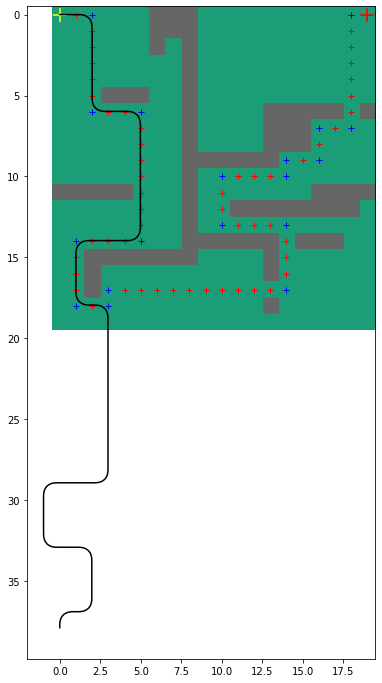

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')
for s in corners:
  ax.plot(s[1],s[0],'b+')
plt.plot(y_traj,x_traj,'k')

This approach of path planning with 90 deg turns just posed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs